<a href="https://colab.research.google.com/github/Cam-Mott/Forecast_series_economicas_VAR_ARIMA_AR/blob/main/series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mLines
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests as granger
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# **Importación de datos y tratamiento estadístico de las series**

---

<br>

Se importan variaciones porcentuales de las variables:

* **EMAE** (Estimador Mensual de Actividad Económica).

* **IS** (Índice de Salarios).

* **IPC** (Índice de Precios al Consumidor).

Estas series fueron construidas a partir de los datos publicados por INDEC, correspondientes al periodo 02/2004 - 02/2010, considerado por varios economistas como "un periodo de relativa estabilidad macroeconómica". Esto último es la hipótesis de partida para suponer que las series pueden ser estacionarias (lo cual efectivamente ocurrie).

<br>



In [42]:
#Importación de datos

url = 'https://docs.google.com/spreadsheets/d/1H1GEIVn99wSA7Qfsu1Tijjq2jd5GYvCSYtJMlqBFt-Y/export?format=csv&gid=474408750'
df = pd.read_csv(url)[['fecha', 'var % EMAE',	'var % IS', "var % IPC"]].iloc[:73]

#Resumen de las series

df.describe()

,var % EMAE,var % IS,var % IPC
count,73.000000,73.000000,73.000000
mean,0.004953,0.014021,0.007061
std,0.054522,0.009770,0.003123
min,-0.088800,-0.029900,0.000000
25%,-0.026900,0.008900,0.004690
50%,-0.006300,0.014600,0.006400
75%,0.023500,0.018400,0.009210
max,0.151900,0.054100,0.015400


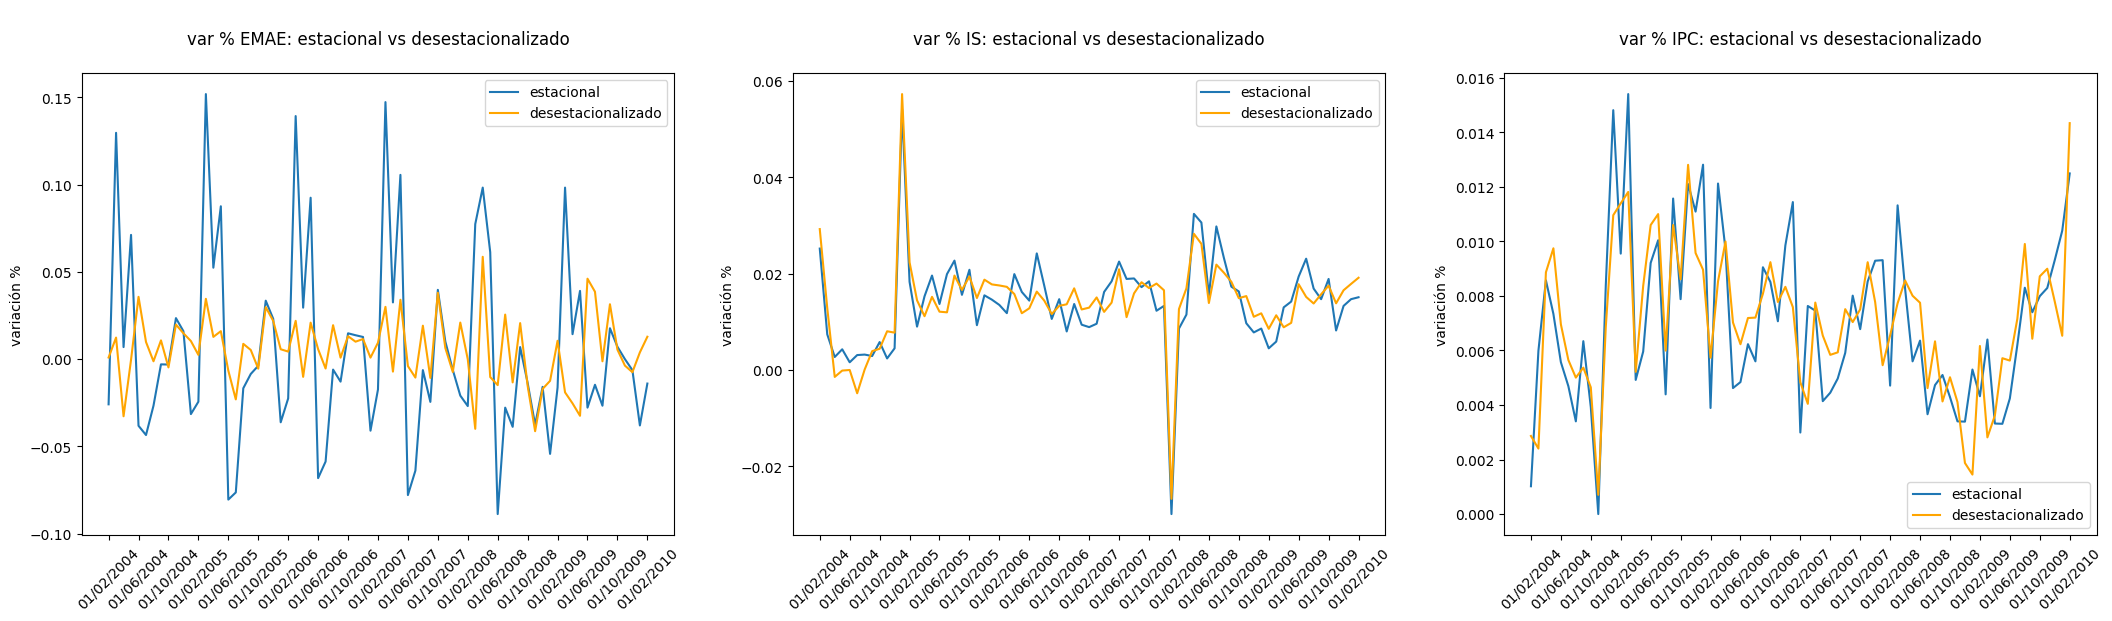

<Figure size 640x480 with 0 Axes>

In [43]:
#Aislamiento del componente estacional

ns_emae = seasonal_decompose(df["var % EMAE"], model = "additive", period = 12).seasonal
ns_is = seasonal_decompose(df["var % IS"], model = "additive", period = 12).seasonal
ns_ipc = seasonal_decompose(df["var % IPC"], model = "additive", period = 12).seasonal

#Gráficos

lista_ns = [ns_emae, ns_is, ns_ipc]
lista_fechas = [list(df.fecha)[x] for x in range(0,len(df),4)]
columnas = list(df.columns[1:])

fig, ax = plt.subplots(1,3,figsize = (26,6))

for grafico,campo in zip(range(3), columnas):

  ax[grafico].plot(df.fecha, df[campo], label = "estacional")
  ax[grafico].plot(df.fecha, df[campo] - lista_ns[grafico], color = "orange", label = "desestacionalizado")
  ax[grafico].set_ylabel('variación %')
  ax[grafico].set_xticks(lista_fechas)
  ax[grafico].set_xticklabels(lista_fechas, rotation = 45)
  ax[grafico].legend()
  ax[grafico].set_title(f'\n{campo}: estacional vs desestacionalizado\n')

plt.show()
plt.tight_layout()

---

<br>

Para cualquiera de los modelos $VAR$, $ARIMA$ o $AR$, es necesario que las series desestacionalizadas sean estacionarias (tengan media y varianza constantes en el tiempo). Es por ello que se plantea la **prueba Dickey-Fuller Aumentada (ADFuller)**. Prueba de hipótesis unilateral-izquierda, el estadístico observado tiene que estar a la izquierda del "valor crítico" para considerar que la serie evaluada es estacionaria. Algunas considerciones:


* Se trabaja con una confianza del 95%.

* La distribución graficada es una distribución hipotética y con fines ilustrativos, dado que el test no se trabaja con una distribución normal.


Como la idea es que los modelos realicen el forecast de los ultimos 6 registros de las series, estos mismos se ecluyen para la prueba **ADFuller**.

<br>


In [44]:
#dataframe para las series desestacionalizadas

df_ns = pd.DataFrame({"fecha": df.fecha,
                      "var % EMAE ns": df["var % EMAE"] - ns_emae,
                      "var % IS ns": df["var % IS"] - ns_is,
                      "var % IPC ns": df["var % IPC"] - ns_ipc
                      })

#Resumen de las series desestacionalizadas

df_ns.describe()

,var % EMAE ns,var % IS ns,var % IPC ns
count,73.000000,73.000000,73.000000
mean,0.005321,0.014076,0.007086
std,0.019669,0.009305,0.002622
min,-0.041303,-0.026736,0.000706
25%,-0.007147,0.011764,0.005628
50%,0.005443,0.014910,0.007159
75%,0.019162,0.017545,0.008607
max,0.058653,0.057264,0.014334


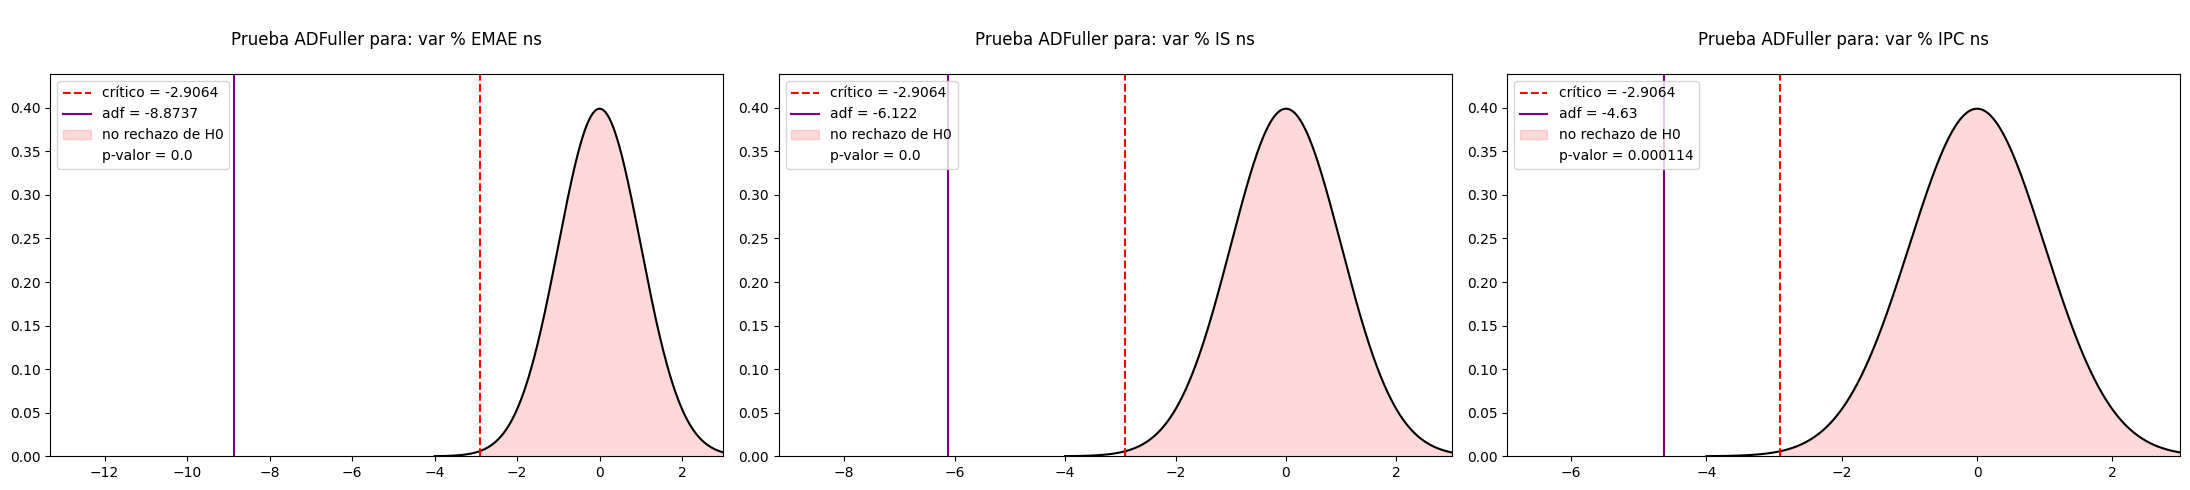

In [45]:
#Coeficientes de la prueba de hipótesis

estadisticos = [float(round(adfuller(df_ns[x][:-6])[0],6)) for x in list(df_ns.columns)[1:]] #valores adf observados
critico = [adfuller(df_ns["var % IPC ns"][:-6])[4]][0]['5%'] #valores críticos de cada prueba
p_valores = [round(adfuller(df_ns[x][:-6])[1],6) for x in list(df_ns.columns)[1:]] #p-valores de cada prueba
variables = list(df_ns.columns)[1:]

#Gráficos prueba ADFuller

fig, ax = plt.subplots(1,3,figsize = (22,5))

for adf, variable, orden in zip(estadisticos, variables, range(3)):

  #valor crítico

  banda_x = np.linspace(critico, 3, 950)
  banda_y = stats.norm.pdf(banda_x)

  #gráfico

  x = np.linspace(-4, 3, 1000)
  y = stats.norm.pdf(x, 0, 1)

  ax[orden].plot(x,y, color = "black")
  ax[orden].set_xlim(adf*1.5, 3)
  ax[orden].set_ylim(0, max(y)*1.1)
  ax[orden].axvline(critico, 0, 1, color = "red", ls = "--", label = f'crítico = {round(critico,4)}') #valor crítico
  ax[orden].axvline(adf, 0, 1, color = "purple", label = f'adf = {round(adf,4)}') #estadístico adf observado
  ax[orden].set_title(f'\nPrueba ADFuller para: {variable}\n')
  ax[orden].fill_between(banda_x, banda_y, color = "red", alpha = 0.15, label = 'no rechazo de H0') #zona de aceptación de H0

  handles, labels = ax[orden].get_legend_handles_labels()

  proxy_pvalor = mLines.Line2D([], [], color='red', ls = 'None',
                                     label=f'p-valor = {p_valores[orden]}')
  handles.append(proxy_pvalor)
  labels.append(proxy_pvalor.get_label())
  ax[orden].legend(handles, labels, loc='best')

plt.tight_layout()
plt.show()

# **Abordando los modelos: VAR, ARIMA y AR**

---
<br>

Vemos que todas las series desestacionalizadas presentan un valor observado ("adf" label, en el gráfico) a la izquierda del valor crítico, así como un p-valor < 0.05. Por ende, todas las series superan el test ADFuller y son estacionarias.

Se procede a abordar el primer modelo: $VAR$ **( Vector AutoRegressive )**.

<br>

El modelo $VAR$ es útil cuando consideramos que puede haber **causalidad recíproca** entre las variables analizadas. Alguna de las dinámicas entre las variables podrían ser:

<br>

*   El incremento en precios lleva a un incremento en salarios nominales, para mantener constantes los salarios reales. A su vez, el incremento en salarios se puede traducir como un incremento en los costos de producción, derivando en inflación de costos.

*   El crecimiento económico tendrá como resultado un incremento en los salarios reales. A su vez, el incremento de salarios reales puede impulsar la demanda interna y potenciar el crecimiento económico. En el mismo camino, la disminución de la inflación lleva a un incremento de salarios reales y por ende un impulso económico.

<br>

La anteriores dinámicas son solo algunos ejemplos de como pueden interactuar las tres variables, en el marco de modelos de equilibrio parcial o de 2 mercados (mercado del producto y mercado del trabajo).

<br>

El modelo $VAR$ construye un sistema de ecuaciones como el siguiente, donde $p$ es el rezago óptimo elegido para el modelo:

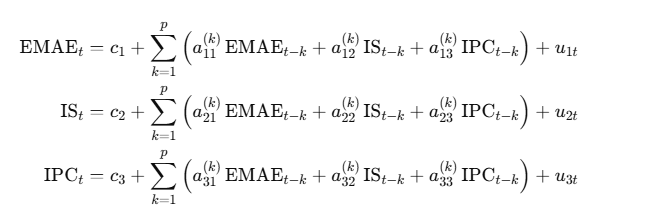

Lo primero que hacemos para abordar el modelo es definir el lag "óptimo". Para ello, se construyen múltiples modelos con distintos valores de rezago $p$ y se comparan sus rendimientos mediante distintos criterios.

<br>


In [46]:
#Lag óptimo, dejando fuera 6 registros para el forecast

modelo = VAR(df_ns.drop(["fecha"], axis = 1)[:-6])
modelo.select_order().summary()

,AIC,BIC,FPE,HQIC
0,-29.30,-29.19*,1.889e-13,-29.26
1,-29.48,-29.04,1.582e-13,-29.31*
2,-29.46,-28.70,1.617e-13,-29.16
3,-29.46,-28.37,1.626e-13,-29.04
4,-29.41,-27.99,1.741e-13,-28.86
5,-29.36,-27.63,1.855e-13,-28.69
6,-29.55,-27.49,1.599e-13,-28.75
7,-29.61,-27.22,1.584e-13,-28.68
8,-29.89,-27.17,1.283e-13*,-28.84
9,-29.90,-26.86,1.395e-13,-28.72


---

<br>

En este caso, tiene sentido guiarse por el **Hannah-Quinn Information Criterion** (**HQIC**), el cual señala que el lag óptimo es *lag = 1*. Tanto **BIC** como **FPE** indica un *lag = 0* como óptimo ( no consistente con un modelo $VAR$ ). El criterio **AIC** señala un *lag = 11* como óptimo ( poco sólido para la cantidad de registros con los que se cuenta ).

<br>

Una vez definido el rezago óptimo, antes de realizar le forecast podemos evaluar si un modelo $VAR$ es adecuado para nuestro caso. Para ello utilizamos el **Test de Causalidad de Granger**. El mismo busca determinar si una variable con rezago, $x_{t-1}$, puede ser generador de otra variable  $y_{t}$. Para ello se construyen dos modelos, uno que incorpora la variable $x_{t-1}$ y otro que no. En base a los errores de cada modelo se construye el estadístico de prueba. En la medida que el modelo que incorpora $x_{t-1}$ tenga precisión explicativa, lo errores de predicción serán menores y por ende el estadístico mayor, al punto que el estadístico supere la hipótesis nula de "no causalidad".

<br>

La manera de evaluar si $x_{t-1}$ puede generar $y_t$ se formula como **"$x$ Granger-causa $y$"**. En este caso, nosotros utilizamos el **Test de Granger Multivariado**, el cual solo excluye el efecto de la variable puesta en duda, pero conserva el efecto del resto de variables del modelo hipotético.

<br>

In [47]:
#Test's de Granger Multivariado

print('p-valor IS Granger causa EMAE:', round(modelo.fit(1).test_causality(caused = 'var % EMAE ns', causing = 'var % IS ns').pvalue,4))
print('p-valor IS Granger causa IPC:', round(modelo.fit(1).test_causality(caused = 'var % IPC ns', causing = 'var % IS ns').pvalue,4))
print('p-valor IPC Granger causa IS:', round(modelo.fit(1).test_causality(caused = 'var % IS ns', causing = 'var % IPC ns').pvalue,4))
print('p-valor IPC Granger causa EMAE:', round(modelo.fit(1).test_causality(caused = 'var % EMAE ns', causing = 'var % IPC ns').pvalue,4))
print('p-valor EMAE Granger causa IPC:', round(modelo.fit(1).test_causality(caused = 'var % IPC ns', causing = 'var % EMAE ns').pvalue,4))
print('p-valor EMAE Granger causa IS:', round(modelo.fit(1).test_causality(caused = 'var % IS ns', causing = 'var % EMAE ns').pvalue,4))

p-valor IS Granger causa EMAE: 0.6502
p-valor IS Granger causa IPC: 0.2271
p-valor IPC Granger causa IS: 0.4282
p-valor IPC Granger causa EMAE: 0.0326
p-valor EMAE Granger causa IPC: 0.0827
p-valor EMAE Granger causa IS: 0.5375


---

<br>

Tomando el primer resultado como ejemplo, vemos que el $p-valor$ de **IS Granger causa EMAE** es igual a 0.6502. Esto quiere decir que la relación de causalidad planteada no superar la hipótesis nula y por ende no hay evidencia estadística significativa para suponer que IS pueda generar EMAE.

<br>

Vemos que la única relación que presenta un $p-valor$ < **0.05** es **IPC Granger causa EMAE**. Esto podría plantear algún tipo de relación de causalidad del IPC sobre el EMAE. Esta relación a su vez no es bidireccional, ya que vemos que el $p-valor$ de **EMAE Granger causa IPC** es igual a 0.08, por lo que tampoco supera la hipótesis nula de no causalidad. El resto de relaciones planteadas tampoco superan el Test de Granger. Por ende, podemos considerar que el modelo $VAR$ no sería el más adecuado.

<br>

Abordamos el siguiente modelo en la lista, el modelo $ARIMA(p, d, q)$ **(AutoRegressive Integrated Movig Average)**.
El componente $( d )$ estará dado por la variación porcentual de las propias series. Resta determinar los componentes $AR( p )$ y $MA( q )$ del modelo. Para ello graficamos las funciones **ACF** y **PACF**: la primera permite definir el orden $( q )$ y la segunda el orden $( p )$.

<br>



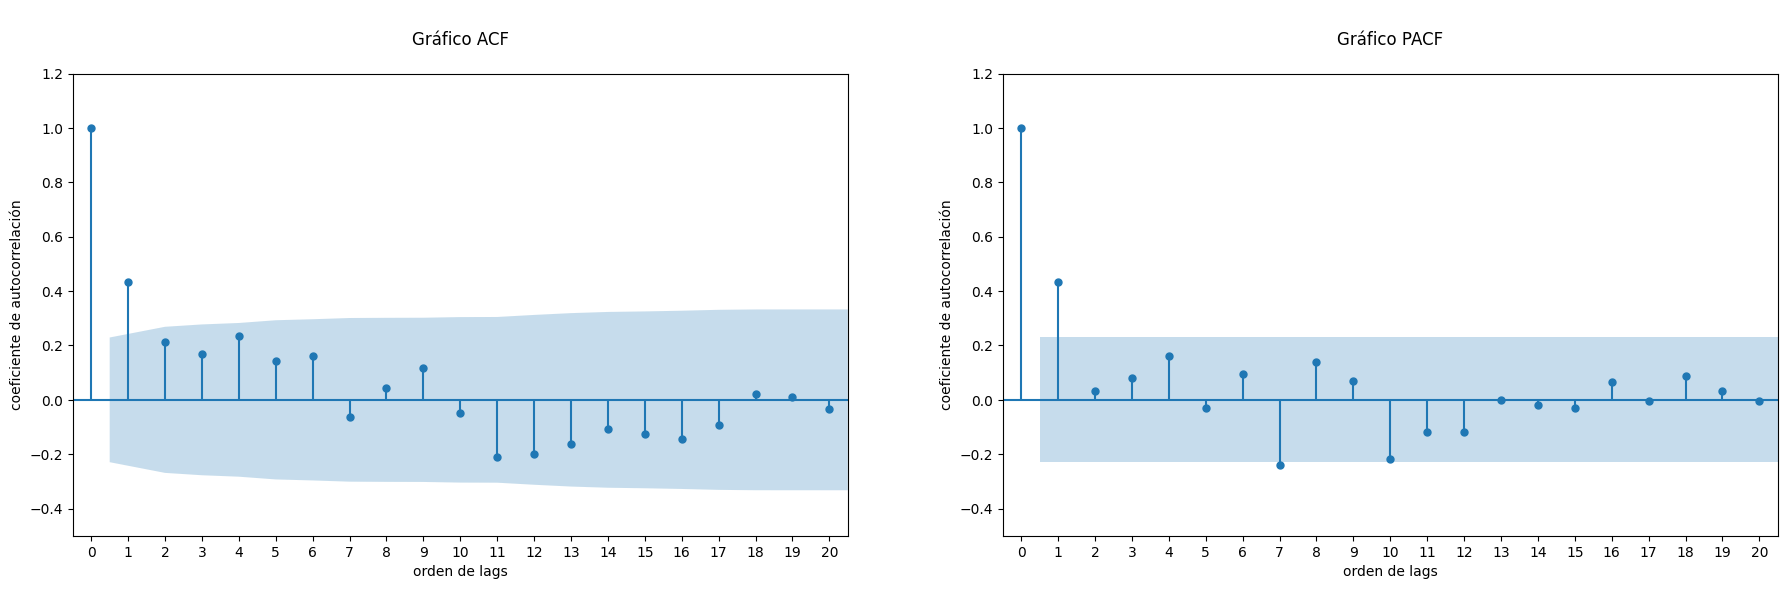

In [48]:
#Ordenes p y q del modelo

fig, ax = plt.subplots(1,2, figsize = (22,6))

plot_acf(df_ns["var % IPC ns"], lags = 20, ax = ax[0])
ax[0].set_title("\nGráfico ACF\n")
ax[0].set_xlabel("orden de lags")
ax[0].set_ylabel("coeficiente de autocorrelación")
ax[0].set_xticks(range(21))
ax[0].set_xlim(-0.5, 20.5)
ax[0].set_ylim(-0.5, 1.2)

plot_pacf(df_ns["var % IPC ns"], lags = 20, ax = ax[1])
ax[1].set_title("\nGráfico PACF\n")
ax[1].set_xlabel("orden de lags")
ax[1].set_ylabel("coeficiente de autocorrelación")
ax[1].set_xticks(range(21))
ax[1].set_xlim(-0.5, 20.5)
ax[1].set_ylim(-0.5, 1.2)

plt.show()

---

<br>

Mientras que el gráfico **ACF** representa la correlación de una serie consigo misma frente a distintos lags (1, 2, etc.), **PACF** representa algo similar, graficando la relación de una serie con el lag de orden $n$ pero dejando de lado el resto de los $n-1$ lag's (por eso la función es "parcial"). El orden $q$ del modelo lo obtenemos observando la función **ACF**, mientras que el orden $p$ observando la función **PACF**.

<br>

En nuestro caso, la función **PACF** presenta un decaimiento brusco a partir del *lag = 1*, mientras que la función **ACF** presenta un comportamiento de tipo "oscilante". En conjunto, los gráficos pueden estar indicando que un modelo $AR( p = 1 )$ sería más apropiado a un modelo $ARIMA(p, d, q)$.

<br>

Para evaluar la correspondencia del modelo para el caso en cuestión, se procede a realizar el test de hipótesis para los coeficientes del modelo $ARIMA(1, 0, 1)$, siendo $p = 1$ y $q = 1$ los ordenes que en menor medida se pueden deducir de los gráficos.

<br>



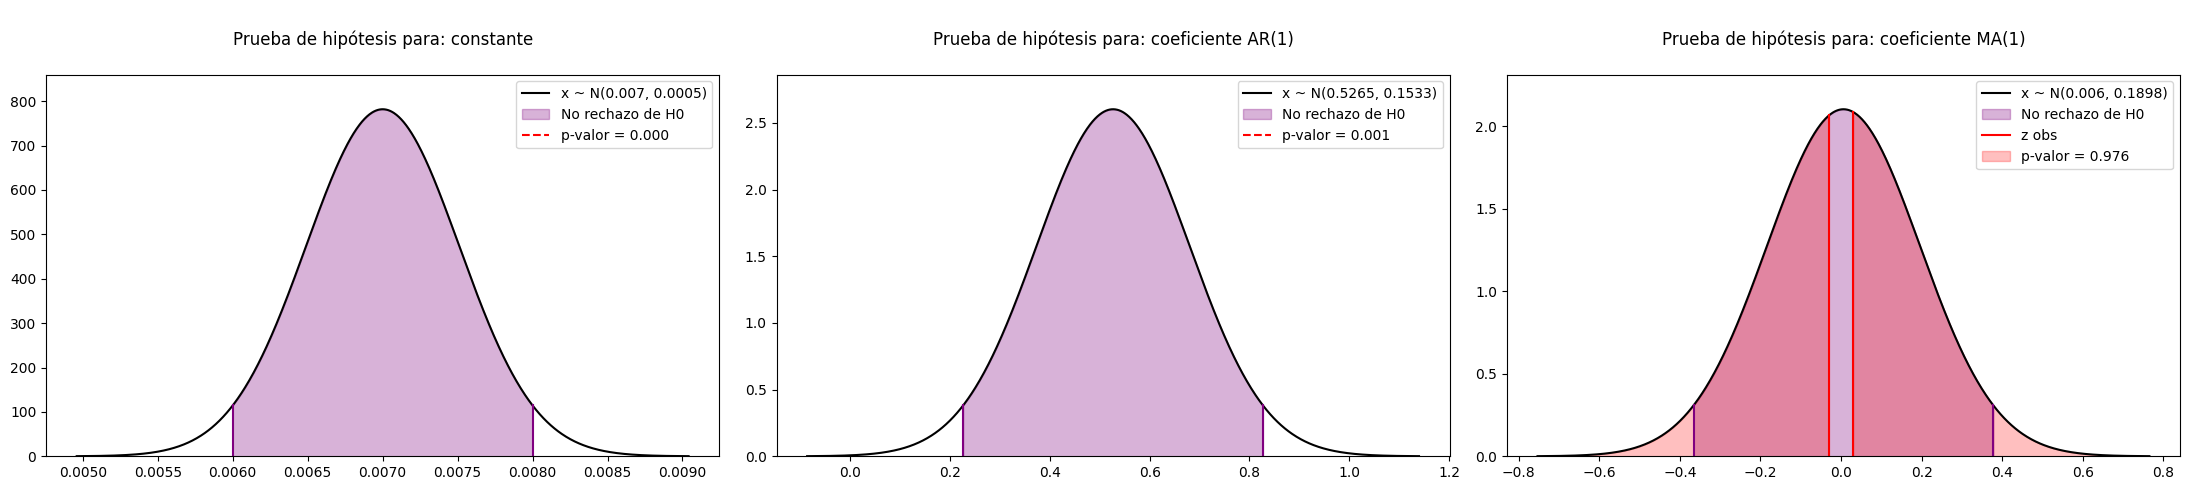

In [49]:
#Ajuste del modelo ARIMA

modelo = ARIMA(df_ns["var % IPC ns"][:-6], order = (1,0,1)).fit() #d = 0 dado que la serie ya se encuentra diferenciada

#Parámetros del modelo

resumen = modelo.summary()
tabla = modelo.summary().tables[1].as_html()
arima = pd.read_html(str(tabla))[0]
arima.columns = list(arima.iloc[0].fillna("var"))
arima = arima.drop(0,axis = 0)

norm = stats.norm
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x)

alpha = 0.05
z_obs = [float(arima.z.iloc[x]) for x in range(3)]
IC_1 = [float(arima["[0.025"].iloc[x]) for x in range(3)]
IC_2 = [float(arima["0.975]"].iloc[x]) for x in range(3)]
coeficientes = ["constante", "coeficiente AR(1)", "coeficiente MA(1)"]

#Prueba de hipótesis para los coefcientes del modelo

fig, ax = plt.subplots(1,3,figsize = (22,5))

for ic1, ic2, z, coeficiente, orden in zip(IC_1, IC_2, z_obs, coeficientes, range(3)):

  #parámetros para la distribución

  media = (ic1 + ic2)/2
  desv = (ic2 -ic1)/3.92
  x = np.linspace(media-4*desv, media+4*desv, 1000)
  y = stats.norm.pdf(x, media, desv)

  #bandas de confianza

  banda_x = np.linspace(ic1, ic2, 950)
  banda_y = stats.norm.pdf(banda_x, media, desv)

  #gráfico

  ax[orden].plot(x,y, color = "black", label = f'x ~ N{round(media,4), round(desv,4)}')
  ax[orden].set_ylim(0, max(y)*1.1)
  ax[orden].set_title(f'\nPrueba de hipótesis para: {coeficiente}\n')

  ax[orden].axvline(ic1, 0, stats.norm.pdf(ic1, media, desv)/(max(y)*1.1), color = "purple")
  ax[orden].axvline(ic2, 0, stats.norm.pdf(ic2, media, desv)/(max(y)*1.1), color = "purple")
  ax[orden].fill_between(banda_x, banda_y, color = "purple", alpha = 0.3,
                 label = f'No rechazo de H0')

  handles, labels = ax[orden].get_legend_handles_labels()

  #p-valor

  if z < media + desv*4:

    p_der = np.linspace(media - 4*desv, -z, 200)
    p_izq = np.linspace(z, media + desv*4, 200)
    py_der = stats.norm.pdf(p_der, media, desv)
    py_izq = stats.norm.pdf(p_izq, media, desv)

    ax[orden].axvline(-z, 0, stats.norm.pdf(-z, media, desv)/(max(y)*1.1), color = "red", label = 'z obs') #-z obs
    ax[orden].axvline(z, 0, stats.norm.pdf(z, media, desv)/(max(y)*1.1), color = "red") #z obs
    plt.fill_between(p_der, py_der, color = "red", alpha = 0.25,
                 label = f'p-valor = {arima["P>|z|"].iloc[orden]}')
    plt.fill_between(p_izq, py_izq, color = "red", alpha = 0.25)
    plt.legend()

  else:

    proxy_pvalor = mLines.Line2D([], [], color='red', linestyle='--',
                                     label=f'p-valor = {arima["P>|z|"].iloc[orden]}')
    handles.append(proxy_pvalor)
    labels.append(proxy_pvalor.get_label())
    ax[orden].legend(handles, labels, loc='best')

plt.tight_layout()
plt.show()

---

<br>

Podemos observar que, en la prueba de hipótesis, el coeficiente asociado al componente $( q )$ del modelo no supera la hipótesis nula; su $p-valor$ = *0.976* > *0.05* y por ende no hay evidencia estadística significativa para suponer que el coeficiente es distinto de 0.

<br>

Por último se ajusta un modelo $AR(p)$. Si bien, tanto el modelo $VAR$ como los gráficos ACF y PACF sugieren que el lag óptimo para el modelo es $p = 1$, realizaremos una prueba particular enfoncandonos en dicho modelo. Para ello comparamos la calidad de ajuste de varios modelos con distintos lag's a través de los coeficientes **AIC** y **BIC**.

<br>


In [50]:
aic = [None]*10
bic = [None]*10
orden = [x for x in range(1,11)] #ordenes p del 1 al 10 para evaluar

for p, posicion in zip(orden, range(10)):
  modelo = AutoReg(df_ns["var % IPC ns"], p).fit() #ajustamos el modelo con un lag = p
  aic[posicion] = modelo.aic
  bic[posicion] = modelo.bic

print(f"El orden de lag con mejor AIC es p = {orden[aic.index(min(aic))]}")
print(f"El orden de lag con mejor BIC es p = {orden[bic.index(min(bic))]}")

El orden de lag con mejor AIC es p = 1
El orden de lag con mejor BIC es p = 1


# **Métricas y comparaciones**

---

<br>

Sobre los modelos $VAR$ y $ARIMA$, vemos que los respectivos test de hipótesis señalan que los modelos no son adecuados; los gráficos ACF y PACF señalan que un modelo $AR$( $ p$=1 ) ajustaría bien, mientras que la comparación de las métricas AIC y BIC señala a $p$ = 1 como el lag óptimo.  

<br>

Con fines de comparar métricas, se ajustan y comparan los 3 modelos a través de la métricas **MAPE**, **RMSE** y **MAE**.
Como se menciono al inicio, la variable de predicción de interés es el **IPC**, por lo que el forecast y las respectivas métricas se compararan en base a las predicciones de la misma.

<br>

In [51]:
#modelo VAR

train, test = df_ns.drop("fecha", axis = 1)[:-6].values, df_ns.drop("fecha", axis = 1)[-6:].values

#forecast iterativo VAR

var = VAR(train)
prediccion_input = train[-1].reshape(1, -1)
predicciones = var.fit(1).forecast(prediccion_input, steps = 6)
iter_var = [float(pred[2]) for pred in predicciones]
iter_var

#rolling forecast VAR

rolling_var_all = []
history_var = list(train)

for p in range(len(test)):
  modelo = VAR(history_var).fit(1)
  forecast = modelo.forecast(history_var[-1].reshape(1, -1), steps = 1)
  rolling_var_all.append(forecast[0])
  history_var.append(test[p])

rolling_var = [roll[2] for roll in rolling_var_all]

In [52]:
#modelo ARIMA

train, test = list(df_ns["var % IPC ns"][:-6]), list(df_ns["var % IPC ns"][-6:])

#forecast iterativo ARIMA

arima = ARIMA(train, order = (1,0,1)).fit() #p = 1, d = 0, q = 1
iter_arima = arima.forecast(6)

#rolling forecast ARIMA

rolling_arima = []
history_arima = train

for p in range(len(test)):
  modelo = ARIMA(history_arima, order = (1,0,1)).fit()
  forecast = modelo.forecast(steps = 1)
  rolling_arima.append(float(forecast[0]))
  history_arima.append(test[p])


In [53]:
#modelo AR

train, test = list(df_ns["var % IPC ns"][:-6]), list(df_ns["var % IPC ns"][-6:])

#forecast iterativo AR

ar = AutoReg(train, lags = 1).fit()
iter_ar = ar.predict(start = len(train), end = len(train) + 5, dynamic = True)

#rolling forecast AR

rolling_ar = []
history_ar = train

for p in range(len(test)):
  modelo = AutoReg(history_ar, lags = 1).fit()
  forecast = modelo.predict(start = len(history_ar), end = len(history_ar))
  rolling_ar.append(float(forecast[0]))
  history_ar.append(test[p])

In [54]:
metricas_iter = np.zeros((3,3))
predicciones_iter = [iter_var, iter_arima, iter_ar]

metricas_roll = np.zeros((3,3))
predicciones_roll = [rolling_var, rolling_arima, rolling_ar]

#cada campo será una métrica y cada fila un modelo, el cual puede ser iterativo o rolling

for p in range(3):

  fila_iter = [round(mape(test,predicciones_iter[p]),6),
               round(rmse(test,predicciones_iter[p]),6),
               round(mae(test,predicciones_iter[p]),6)]
  metricas_iter[p, :] = fila_iter

for p in range(3):

  fila_roll = [round(mape(test,predicciones_roll[p]),6),
               round(rmse(test,predicciones_roll[p]),6),
               round(mae(test,predicciones_roll[p]),6)]
  metricas_roll[p, :] = fila_roll

#resumen de metricas

metricas = np.vstack((metricas_iter, metricas_roll))
df_metricas = pd.DataFrame(metricas, columns = ['MAPE', 'RMSE', 'MAE'])
df_metricas["modelo"] = ['VAR (iter)', 'ARIMA (iter)', 'AR (iter)',
                         'VAR (roll)', 'ARIMA (roll)', 'AR (roll)']
df_metricas = df_metricas.set_index('modelo')
df_metricas.T

modelo,VAR (iter),ARIMA (iter),AR (iter),VAR (roll),ARIMA (roll),AR (roll)
MAPE,0.203344,0.214479,0.210734,0.194419,0.231103,0.228858
RMSE,0.003125,0.003229,0.003157,0.003186,0.003381,0.003339
MAE,0.002097,0.002194,0.002143,0.002040,0.002341,0.002311


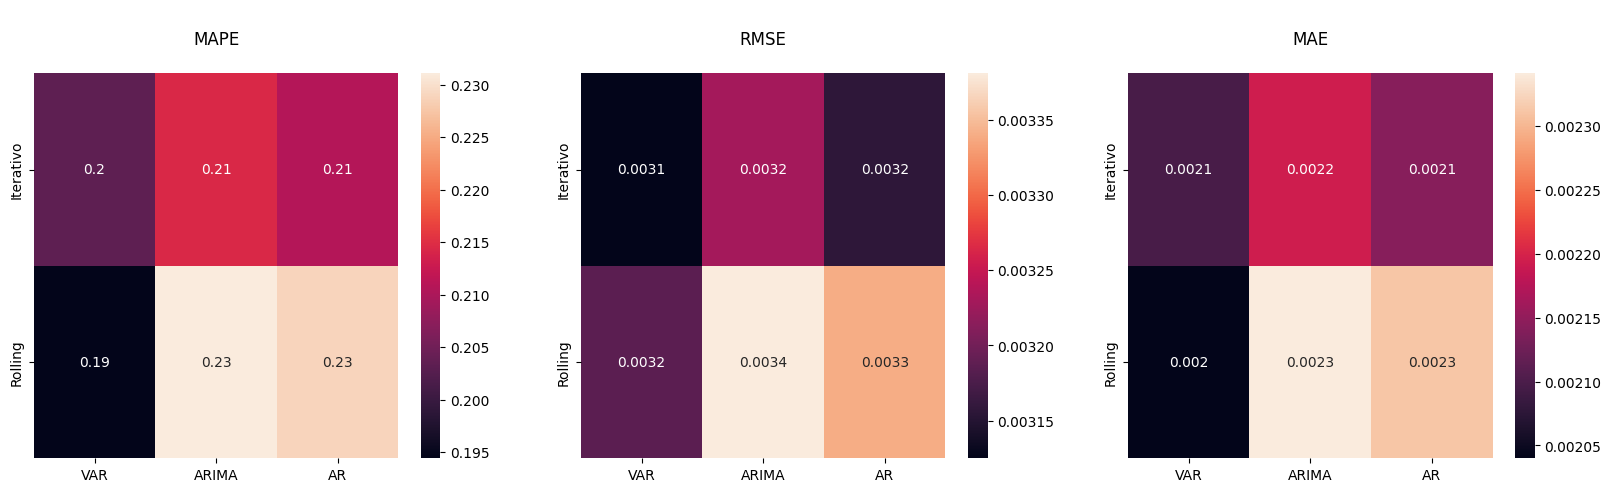

In [55]:
#Mapa de calor de las métricas

fig, ax = plt.subplots(1,3,figsize = (20,5))

for p, metricas in zip(range(3), ["MAPE", "RMSE", "MAE"]):
  sns.heatmap(np.vstack((np.array([df_metricas.T.iloc[p][0:3]]), np.array(df_metricas.T.iloc[p][3:]))),
              ax = ax[p], annot = True)
  ax[p].set_title(f"\n{metricas}\n")
  ax[p].set_xticklabels(["VAR", "ARIMA", "AR"])
  ax[p].set_yticklabels(["Iterativo", "Rolling"])

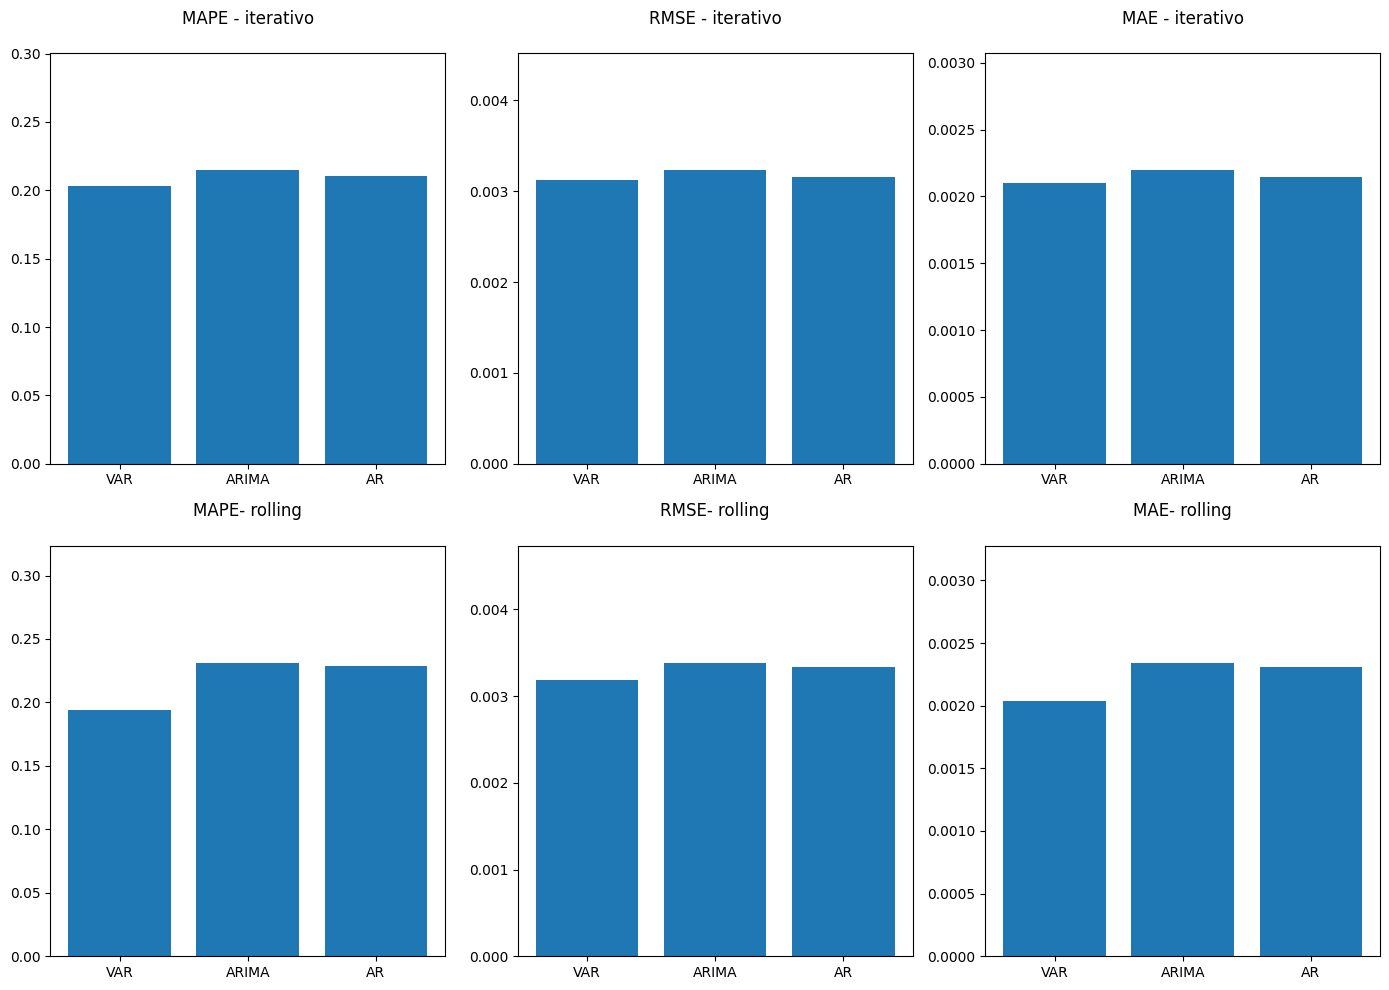

In [56]:
#Reprentación gráfica de las métricas

df_iter = df_metricas.T.drop(["VAR (roll)","ARIMA (roll)","AR (roll)"], axis = 1)
df_roll = df_metricas.T.drop(["VAR (iter)","ARIMA (iter)","AR (iter)"], axis = 1)

fig, ax = plt.subplots(2,3, figsize = (14,10))

for fila in range(6):

  if fila < 3:
    ax[0,fila].bar(["VAR", "ARIMA", "AR"], list(df_iter.iloc[fila]))
    ax[0,fila].set_title(f"{df_iter.iloc[fila].name} - iterativo\n")
    ax[0,fila].set_ylim(0,max(list(df_iter.iloc[fila]))*1.4)

  else:
    ax[1,fila-3].bar(["VAR", "ARIMA", "AR"], list(df_roll.iloc[fila-3]))
    ax[1,fila-3].set_title(f"{df_roll.iloc[fila-3].name}- rolling\n")
    ax[1,fila-3].set_ylim(0,max(list(df_roll.iloc[fila-3]))*1.4)

plt.tight_layout()
plt.show()

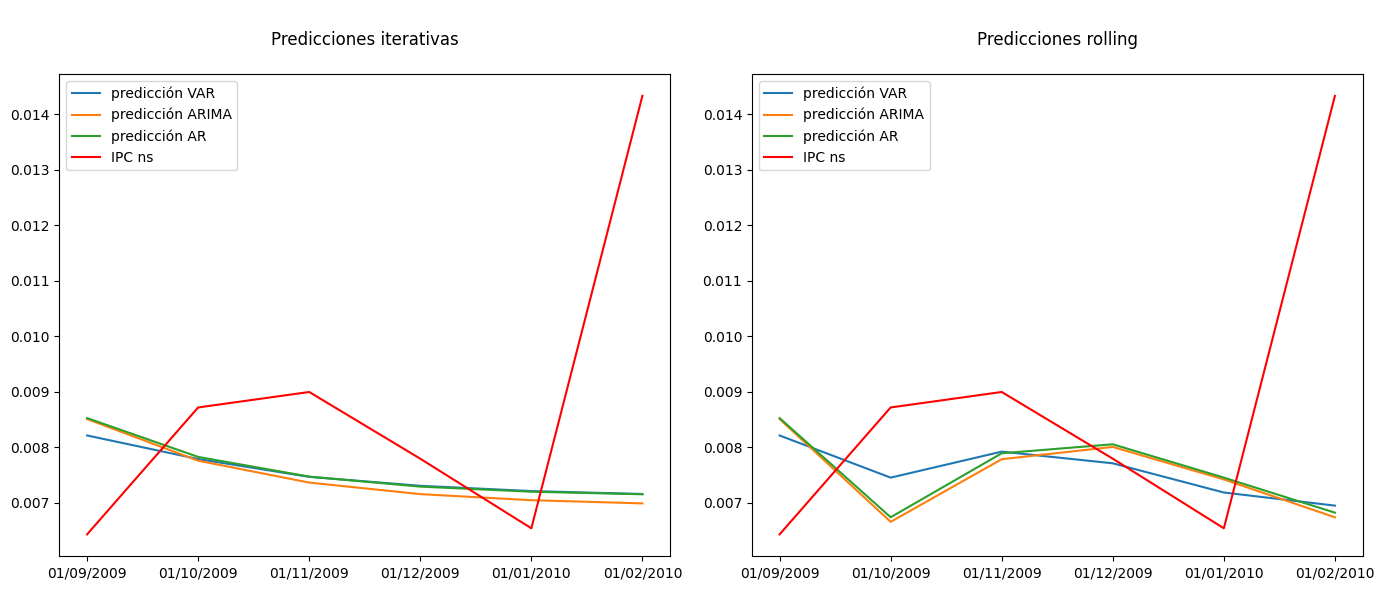

In [57]:
#Predicciones

fig, ax = plt.subplots(1,2,figsize = (14,6))

for p, modelo in zip(range(3), ["VAR", "ARIMA", "AR"]):

  ax[0].plot(df.fecha[-6:].values, predicciones_iter[p], label = f"predicción {modelo}")
  ax[0].legend()
  ax[1].plot(df.fecha[-6:].values, predicciones_roll[p], label = f"predicción {modelo}")
  ax[1].legend()

ax[0].plot(df.fecha[-6:].values, df_ns["var % IPC ns"][-6:], color = "red", label = "IPC ns")
ax[0].set_title("\nPredicciones iterativas\n")
ax[0].legend()

ax[1].plot(df.fecha[-6:].values, df_ns["var % IPC ns"][-6:], color = "red", label = "IPC ns")
ax[1].set_title("\nPredicciones rolling\n")
ax[1].legend()

plt.tight_layout()
plt.show()

---

<br>

Si observarmos las métricas construidas, podremos observar dos cuestiones. La primera de ellas es que los 3 modelos presentan métricas muy similares entre sí. No se ven diferencias significativas entre ellos en términos de rendimientos predictivos. En segundo lugar y, observando más en detalle, vemos que los modelos **VAR** y **AR** presentan mejores métricas que el modelo **ARIMA**. Solo en el **MAPE rolling** podemos observar una diferencia de 4 puntos porcentuales, donde **VAR** se posiciona con menor margen de eror porcentual que **AR**. Luego, tanto en **RMSE** como en **MAE**, las diferencias entre ambos son irrisorias (aunque, nuevamente, **VAR** se posiciona por poco mejor que **AR**).

<br>

El  "*Principio de Parsimonia* " (también conocido como " *Navaja de Ockham* "), aplicado al contexto de los modelos de predicción, nos indica que frente a modelos que predicen con rendimientos similares, debemos optar por aquel más simple. Esto debido a que el modelo simple será menos propenso al overfitting, más fácil de interpretar y más robusto. Siendo que al comparar los modelos no se registran diferencias significativas en términos de calidad predictiva, lo más lógico sería optar por el modelo $AR(p = 1)$.

<br>

Por otra parte, no debemos pasar por alto que, como se ve en los gráficos y particularmente en el forecast de tipo rolling, los modelos no solo parecen no capturar la tendencia del comportamiento real de la serie, sino que además solo parecen poder predecir los valores pasados. Esto no es mucho, considerando que los mismos son el input de los 3 modelos.